# Making a simple map of a variable

---

## Overview
Take the data we read in in the previous notebook, and learn how to make a simple map of a few different variables.

1. Spin up a Dask cluster and load the data
2. Super quick plot
3. Two nicer plots on a map projection

## Prerequisites

| Concepts | Importance | Notes |
| --- | --- | --- |
| [Dask Cookbook](https://projectpythia.org/dask-cookbook/README.html) | Helpful | |
| [Intro to Xarray](https://foundations.projectpythia.org/core/xarray.html) | Helpful | |
| [Matplotlib](https://foundations.projectpythia.org/core/matplotlib.html) | Necessary | |
| [Intro to Cartopy](https://foundations.projectpythia.org/core/cartopy/cartopy.html) | Necessary | |


- **Time to learn**: 10 min


---

## Imports

In [1]:
import xarray as xr
from dask.distributed import LocalCluster
import glob
import numpy as np
import matplotlib.pyplot as plt
import cartopy
import cartopy.crs as ccrs
import pop_tools


## Connect to cluster

In [2]:
cluster = LocalCluster()
client = cluster.get_client()

/glade/work/eromashkova/miniconda3/envs/ocean-bgc-cookbook-dev/lib/python3.12/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 41511 instead
  warnings.warn(


## Load the data

In [3]:
case = 'g.e22.GOMIPECOIAF_JRA-1p4-2018.TL319_g17.4p2z.002branch'
path = '/glade/derecho/scratch/eromashkova/ocean-bgc-cookbook-data/cesm/'+case+'/ocn/proc/tseries/month_1'
coords = {'x':'TLONG','y':'TLAT'}
path

'/glade/derecho/scratch/eromashkova/ocean-bgc-cookbook-data/cesm/g.e22.GOMIPECOIAF_JRA-1p4-2018.TL319_g17.4p2z.002branch/ocn/proc/tseries/month_1'

In [4]:
files = glob.glob(f'{path}/{case}.pop.h.*.201001-201912.nc')
ds=xr.open_mfdataset(files, data_vars="minimal", coords='minimal', compat="override", parallel=True,
                       drop_variables=["transport_components", "transport_regions", 'moc_components'], decode_times=True)
ds

<xarray.Dataset> Size: 28GB
Dimensions:                         (nlat: 384, nlon: 320, time: 120, z_t: 60,
                                     z_t_150m: 15)
Coordinates:
    TLAT                            (nlat, nlon) float64 983kB dask.array<chunksize=(384, 320), meta=np.ndarray>
    TLONG                           (nlat, nlon) float64 983kB dask.array<chunksize=(384, 320), meta=np.ndarray>
  * time                            (time) object 960B 2010-01-16 12:00:00 .....
  * z_t                             (z_t) float32 240B 500.0 ... 5.375e+05
  * z_t_150m                        (z_t_150m) float32 60B 500.0 ... 1.45e+04
Dimensions without coordinates: nlat, nlon
Data variables: (12/45)
    FG_CO2                          (time, nlat, nlon) float32 59MB dask.array<chunksize=(60, 192, 160), meta=np.ndarray>
    Fe                              (time, z_t, nlat, nlon) float32 4GB dask.array<chunksize=(30, 15, 96, 80), meta=np.ndarray>
    NO3                             (time, z_t, nlat, nlon) float32 4GB dask.array<chunksize=(30, 15, 96, 80), meta=np.ndarray>
    PO4                             (time, z_t, nlat, nlon) float32 4GB dask.array<chunksize=(30, 15, 96, 80), meta=np.ndarray>
    POC_FLUX_100m                   (time, nlat, nlon) float32 59MB dask.array<chunksize=(60, 192, 160), meta=np.ndarray>
    SALT                            (time, z_t, nlat, nlon) float32 4GB dask.array<chunksize=(30, 15, 96, 80), meta=np.ndarray>
    ...                              ...
    sp_Fe_lim_Cweight_avg_100m      (time, nlat, nlon) float32 59MB dask.array<chunksize=(60, 192, 160), meta=np.ndarray>
    sp_Fe_lim_surf                  (time, nlat, nlon) float32 59MB dask.array<chunksize=(60, 192, 160), meta=np.ndarray>
    sp_N_lim_Cweight_avg_100m       (time, nlat, nlon) float32 59MB dask.array<chunksize=(60, 192, 160), meta=np.ndarray>
    sp_N_lim_surf                   (time, nlat, nlon) float32 59MB dask.array<chunksize=(60, 192, 160), meta=np.ndarray>
    sp_P_lim_Cweight_avg_100m       (time, nlat, nlon) float32 59MB dask.array<chunksize=(60, 192, 160), meta=np.ndarray>
    sp_P_lim_surf                   (time, nlat, nlon) float32 59MB dask.array<chunksize=(60, 192, 160), meta=np.ndarray>

## Super quick plot

We use xarray's `isel()` (select by index) function to grab the first entry in time and vertical coordinate available in our data set. Note that our dataset has some metadata associated with it, so xarray knows that the units are in degrees Celsius without us manually specifying. Xarray's `plot()` function is great for looking at data quickly to make sure things look right before diving into more involved analysis or plotting

We arbitrarily choose to plot temperature, but there are lots of options for variables to plot!

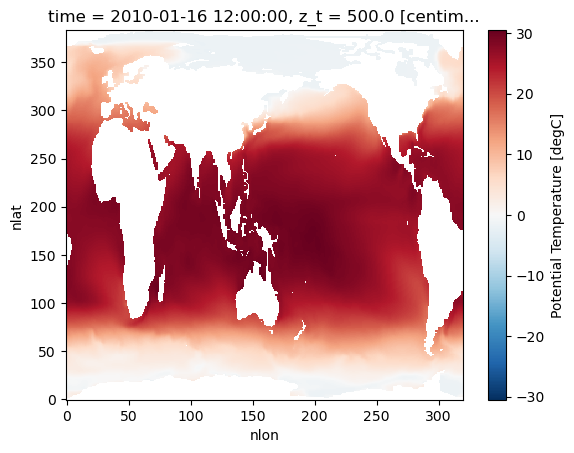

In [5]:
ds["TEMP"].isel(time=0, z_t=0).plot()

## Making a plot on a nicer map projection

### Bringing in some POP grid tools
This version of CESM uses [POP2](https://www.cesm.ucar.edu/models/pop) (the Parallel Ocean Program) as its ocean model. All of the ocean variable output is on the POP grid, which requires some extra wrangling to get it to work properly with standard mapping utilities.

In [6]:
ds_grid = pop_tools.get_grid('POP_gx1v7')
lons = ds_grid.TLONG
lats = ds_grid.TLAT
depths = ds_grid.z_t * 0.01

In [7]:
def adjust_pop_grid(tlon,tlat,field):
    nj = tlon.shape[0]
    ni = tlon.shape[1]
    xL = int(ni/2 - 1)
    xR = int(xL + ni)

    tlon = np.where(np.greater_equal(tlon,min(tlon[:,0])),tlon-360.,tlon)
    lon  = np.concatenate((tlon,tlon+360.),1)
    lon = lon[:,xL:xR]

    if ni == 320:
        lon[367:-3,0] = lon[367:-3,0]+360.
    lon = lon - 360.
    lon = np.hstack((lon,lon[:,0:1]+360.))
    if ni == 320:
        lon[367:,-1] = lon[367:,-1] - 360.

    # Trick cartopy into doing the right thing:
    # it gets confused when the cyclic coords are identical
    lon[:,0] = lon[:,0]-1e-8
    
    # Periodicity
    lat  = np.concatenate((tlat,tlat),1)
    lat = lat[:,xL:xR]
    lat = np.hstack((lat,lat[:,0:1]))

    field = np.ma.concatenate((field,field),1)
    field = field[:,xL:xR]
    field = np.ma.hstack((field,field[:,0:1]))
    return lon,lat,field

### Making the map

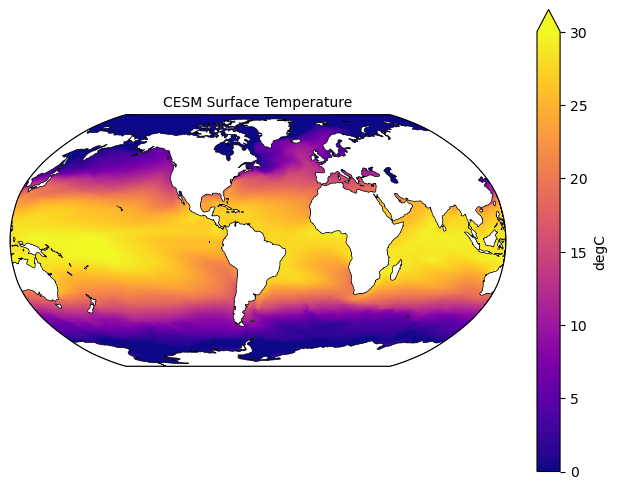

In [8]:
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(1,1,1, projection=ccrs.Robinson(central_longitude=305.0))

# Using the utilities we added above to process our data, and plotting it
lon, lat, field = adjust_pop_grid(lons, lats, ds["TEMP"].isel(time=0, z_t=0))
pc1=ax.pcolormesh(lon, lat,field, cmap='plasma',
                  vmin=0, vmax=30,
                 transform=ccrs.PlateCarree())

# Adding the land features
land = cartopy.feature.NaturalEarthFeature('physical', 'land', scale='110m', edgecolor='k', facecolor='white', linewidth=0.5)
ax.add_feature(land)

# Adding colorbar and title
cbar1 = fig.colorbar(pc1, ax=ax,extend='max',label=ds["TEMP"].units)
ax.set_title('CESM Surface Temperature', fontsize=10)

plt.show()

Let's try the same thing with another variable, salinity (`SALT`). We replace which variable we're extracting from `ds` in the `adjust_pop_grid()` function, where we preprocess the data. If you're trying this on your own, some other good ones to try looking at are dissolved inorganic carbon (`DIC`), oxygen (`O2`), or pH (`PH`).

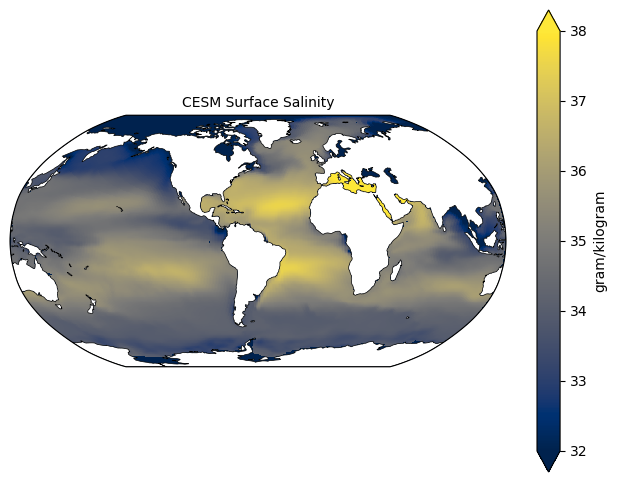

In [9]:
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(1,1,1, projection=ccrs.Robinson(central_longitude=305.0))

# Using the utilities we added above to process our data, and plotting it
lon, lat, field = adjust_pop_grid(lons, lats, ds['SALT'].isel(time=0, z_t=0))

# Pick a different colorscheme from the plot above so we can distinguish them more easily
pc1=ax.pcolormesh(lon, lat,field, cmap='cividis',
                  vmin=32, vmax=38,
                 transform=ccrs.PlateCarree())

# Adding the land features
land = cartopy.feature.NaturalEarthFeature('physical', 'land', scale='110m', edgecolor='k', facecolor='white', linewidth=0.5)
ax.add_feature(land)

# Adding colorbar and title
cbar1 = fig.colorbar(pc1, ax=ax,extend='both',label=ds["SALT"].units)
ax.set_title('CESM Surface Salinity', fontsize=10)

plt.show()

Close the Dask cluster we spun up at the beginning.

In [10]:
cluster.close()

---

## Summary
You've learned how to make simple plots of CESM output.

## Resources and references

- [Dask tutorial](https://tutorial.dask.org/)